In [1]:
import pandas as pd
import numpy as np
import geopandas as gp

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import utils.preprocess_funcs as pf

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
colors = ['#18A558', '#A3EBB1', '#21B6A8', '#116530']

In [4]:
LAST_REVIEW_DAYS = 180
LAST_CALENDAR_UPD = 60

## Boston Airbnb data analysis

#### listing - description of airbnb objects

In [96]:
listing = pd.read_csv('Boston_Airbnb_data/listings.csv')
listing[:1]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN


In [97]:
print('Dates of the listing data scraping: ', listing['last_scraped'].unique())

Dates of the listing data scraping:  ['2016-09-07']


In [98]:
# preprocess columns with prices
price_columns = ['price', 'weekly_price', 'monthly_price', 'cleaning_fee', 'security_deposit']
for col in price_columns:
    listing = pf.convert_price_to_num(listing,
                                  price_col_name=col,
                                  output_col_name=col)
    
# preprocess columns with rates
rate_columns = ['host_response_rate', 'host_acceptance_rate']
for col in rate_columns:
    listing = pf.convert_rate_to_num(listing,
                                  rate_col_name=col,
                                  output_col_name=col)
    
# preprocess amenities description
listing['amenities'] = listing['amenities'].apply(lambda x: pf.preprocess_amenities(x))

# calculate days from last review
listing['days_from_last_review'] = ( pd.to_datetime(listing['last_scraped']) - 
                                     pd.to_datetime(listing['last_review']) ).dt.days


# define date of last calendar update
date_to = listing['calendar_last_scraped'].unique()[0]
listing['calendar_upd_date'] = listing['calendar_updated'].apply(lambda x: pf.get_past_date(date_to=date_to, 
                                                                                            str_days_ago=x))
# calculate days from last calendar update
listing['days_from_calendar_upd'] = ( pd.to_datetime(listing['calendar_last_scraped']) - 
                                      pd.to_datetime(listing['calendar_upd_date']) ).dt.days

# add columns for further filtering
listing['recently_booked'] = (listing['days_from_last_review']<LAST_REVIEW_DAYS).astype(int)
listing['recently_calendar_upd'] = (listing['days_from_calendar_upd']<LAST_CALENDAR_UPD).astype(int)

# remove empty columns
listing = listing.dropna(how='all', axis=1)
# remove dummy columns
dummy_cols = ['experiences_offered', 'requires_license', 'host_total_listings_count']
listing = listing.drop(columns=dummy_cols)

In [80]:
# create shape file for further visualisation
listing_geo = listing[['id', 'city', 'state', 'zipcode', 
                       'neighbourhood', 'neighbourhood_cleansed',
                       'street',
                       'latitude', 'longitude', 'is_location_exact']+price_columns]
listing_gdf = gp.GeoDataFrame(listing_geo, 
                              geometry=gp.points_from_xy(listing_geo['longitude'], 
                                                         listing_geo['latitude']),
                             crs='EPSG:4326')

listing_gdf.to_file('geo_data/listing_gdf/listing_gdf.shp')

#### add districts to the listing info

In [81]:
district_map = gp.read_file('geo_data/Planning_Districts/Planning_Districts.shp')[['PD', 'geometry']]
district_map = district_map.rename(columns={'PD': 'district'})
# calculate district area in square kilometers
district_map['area_km2'] = district_map['geometry'].to_crs({'init': 'epsg:3857'}).area/1e6

In [82]:
listings_w_districts = gp.overlay(listing_gdf, district_map, how='intersection')

In [100]:
listing = listing.merge(listings_w_districts[['id', 'district', 'area_km2']],
                        on='id', how='left')

#### Quick look at listings

In [84]:
# consider only recently_booked == 1 & recently_calendar_upd == 1
sample = listing[ (listing['recently_booked']==1) 
                & (listing['recently_calendar_upd']==1) ]
selected_ids = sample['id'].unique()

In [85]:
len(sample)

1870

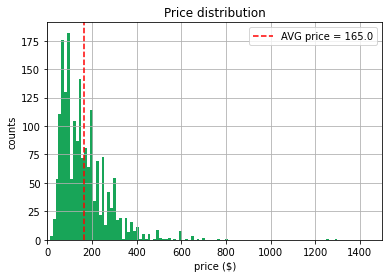

In [86]:
sample['price'].hist(bins=100, color=colors[0])
plt.axvline(x=sample['price'].mean(), linestyle='--', 
            color='red', label=f'AVG price = {round(sample["price"].mean(), 0)}')
plt.xlim(0,1500)
plt.title('Price distribution')
plt.xlabel('price ($)')
plt.ylabel('counts')
plt.legend()
plt.show()

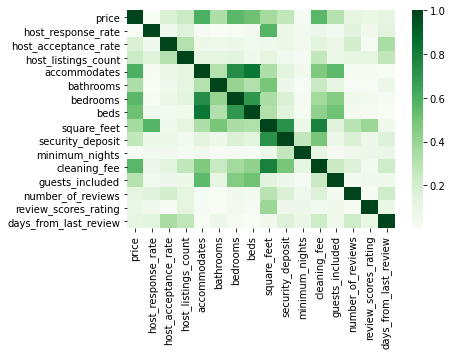

In [87]:
cols_of_interest = ['price', 'host_response_rate', 'host_acceptance_rate', 
                    'host_listings_count','accommodates',
                    'bathrooms', 'bedrooms', 'beds', 'square_feet', 
                    'security_deposit', 'minimum_nights',
                    'cleaning_fee', 'guests_included',
                    'number_of_reviews', 'review_scores_rating',
                    'days_from_last_review']
sns.heatmap(abs(sample[cols_of_interest].corr()),
           cmap='Greens')
plt.show()

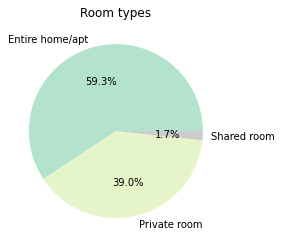

In [88]:
stat = sample['room_type'].fillna('n/a').value_counts()/len(sample)
stat.plot(kind='pie', colormap='Pastel2', autopct='%1.1f%%')
plt.title('Room types')
plt.ylabel('')
plt.show()

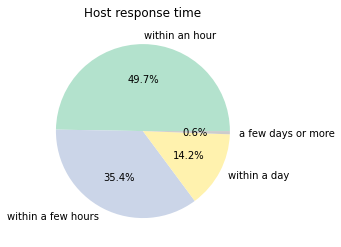

In [89]:
selection = sample['host_response_time'].dropna()
stat = selection.value_counts()/len(selection)*100
stat.plot(kind='pie', colormap='Pastel2', autopct='%1.1f%%')
plt.title('Host response time')
plt.ylabel('')
plt.show()

In [93]:
district_col = 'district'
district_stat = (sample
                 .groupby([district_col, 'area_km2'])
                 .agg({'price': 'mean',
                       'id': 'count',
                       'review_scores_rating': 'mean'})
                 .reset_index())
district_stat = district_stat.rename(columns={'id': 'num_listings'})
district_stat['density'] = district_stat['num_listings']/district_stat['area_km2']
district_stat = district_stat.sort_values(by=['price'], ascending=True)

In [105]:
listing = listing.merge(district_stat[['district', 'density']], on='district', how='left')

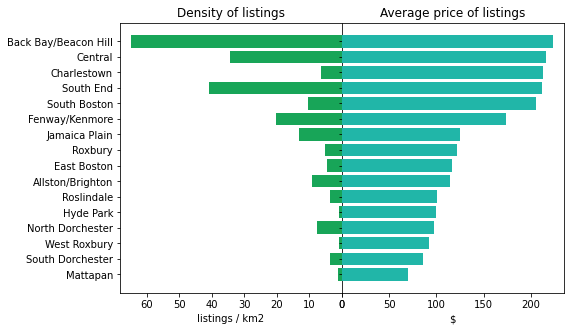

In [102]:
fig, axes = plt.subplots(figsize=(8,5), ncols=2, sharey=True)
fig.tight_layout()

# density
axes[0].barh(district_stat[district_col], district_stat['density'], 
             align='center', zorder=10, color=colors[0])
axes[0].set_title('Density of listings')
axes[0].set_xlabel('listings / km2')
axes[0].invert_xaxis() 

# price
axes[1].barh(district_stat[district_col], district_stat['price'], 
             align='center', zorder=10, color=colors[2])
axes[1].set_title('Average price of listings')
axes[1].set_xlabel('$')
plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)

#### calendar - info about object prices and availability

In [21]:
calendar = pd.read_csv('Boston_Airbnb_data/calendar.csv')
calendar[:2]

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN


In [22]:
print('Date ranges in the calendar data: ', calendar['date'].min(), '-', calendar['date'].max())

Date ranges in the calendar data:  2016-09-06 - 2017-09-05


In [23]:
print('Dates of calendar scraping: ', listing['calendar_last_scraped'].unique())

Dates of calendar scraping:  ['2016-09-06']


In [24]:
# preprocess price column
calendar = pf.convert_price_to_num(calendar, 'price', 'price')

# preprocess date
# day of week
week_days = {0: 'Monday',
            1: 'Tuesday',
            2: 'Wednesday',
            3: 'Thursday',
            4: 'Friday',
            5: 'Saturday',
            6: 'Sunday'}
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['day_of_week_num'] = calendar['date'].dt.dayofweek
calendar['day_of_week_name'] = calendar['day_of_week_num'].map(week_days)
calendar['weekend'] = (calendar['day_of_week_name'].isin(['Friday', 'Saturday'])).astype(int)
# month
calendar['month'] = calendar['date'].dt.month

# preprocess available
available_map = {'f': 0, 't': 1}
calendar['available_code'] = calendar['available'].map(available_map)
calendar['available_lid'] = calendar['available_code']*calendar['listing_id']

In [25]:
calendar[:2]

,listing_id,date,available,price,day_of_week_num,day_of_week_name,weekend,month,available_code,available_lid
0,12147973,2017-09-05,f,NaN,1,Tuesday,0,9,0,0
1,12147973,2017-09-04,f,NaN,0,Monday,0,9,0,0


### Aggregate calendar stat

In [26]:
calendar_sample = calendar[calendar['listing_id'].isin(selected_ids)]

In [27]:
# overall availability
availability = pd.pivot_table(calendar_sample, 
                              index='listing_id', 
                              columns='available', 
                              values='date', 
                              aggfunc='count').reset_index().fillna(0)
availability = availability.rename(columns={'f': 'not_available',
                                            't': 'available'})
availability['total_days'] = availability['available'] + availability['not_available']
availability['available_share'] = availability['available']/availability['total_days']
availability[:2]

available,listing_id,not_available,available,total_days,available_share
0,6695,41.0,324.0,365.0,0.887671
1,6976,46.0,319.0,365.0,0.873973


51.7 % of objects are available more then 60% of year


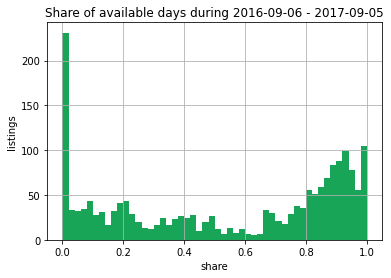

In [28]:
mostly_available = len(availability[availability['available_share']>=0.6])
mostly_available_share = mostly_available/len(availability)*100
print(round(mostly_available_share, 1), '% of objects are available more then 60% of year')

availability['available_share'].hist(bins=50, color=colors[0])
plt.title('Share of available days during 2016-09-06 - 2017-09-05')
plt.xlabel('share')
plt.ylabel('listings')
plt.show()

In [29]:
# add avg price
avg_price_tab = calendar_sample.groupby('listing_id').agg({'price': 'mean'}).reset_index()

availability = availability.merge(avg_price_tab, on='listing_id', how='left')
availability[:2]

,listing_id,not_available,available,total_days,available_share,price
0,6695,41.0,324.0,365.0,0.887671,197.407407
1,6976,46.0,319.0,365.0,0.873973,65.000000


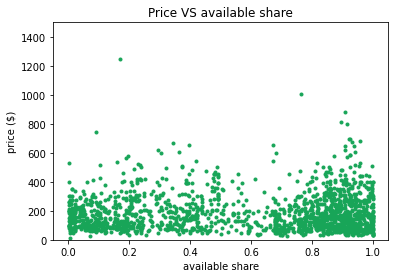

In [30]:
plt.plot(availability['available_share'], availability['price'], 
         '.', color=colors[0])
plt.title('Price VS available share')
plt.xlabel('available share')
plt.ylabel('price ($)')
plt.ylim(0, 1500)
plt.show()

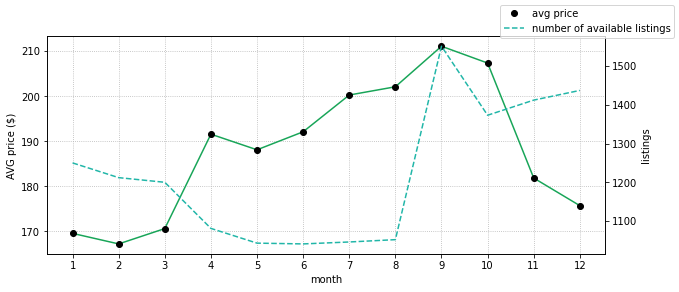

In [166]:
month_stat = (calendar_sample
              .groupby('month')
              .agg({'price': 'mean',
                    'available_lid': pd.Series.nunique})
              .reset_index())

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(111)
ax1.plot(month_stat['month'], month_stat['price'],
        color=colors[0])
ax1.plot(month_stat['month'], month_stat['price'], 
         '.', color='black', markersize=12, label='avg price')
ax1.set_xticks(month_stat['month'].unique())
ax1.set_xlabel('month')
ax1.set_ylabel('AVG price ($)')
ax1.grid(linestyle=':')

ax2 = ax1.twinx()
ax2.plot(month_stat['month'], 
         month_stat['available_lid'],
        linestyle='--',
        color=colors[2],
        label='number of available listings')
ax2.set_ylabel('listings')

fig.legend()
plt.show()

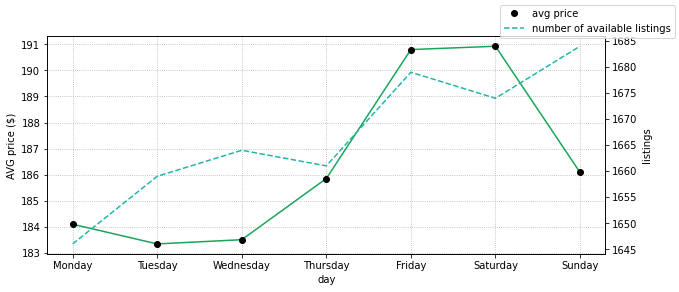

In [165]:
week_day_stat = (calendar_sample
                 .groupby(['day_of_week_num', 'day_of_week_name'])
                 .agg({'price': 'mean',
                       'available_lid': pd.Series.nunique})
                 .reset_index())

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(111)
ax1.plot(week_day_stat['day_of_week_name'], week_day_stat['price'],
        color=colors[0])
ax1.plot(week_day_stat['day_of_week_name'], week_day_stat['price'], 
         '.', color='black', markersize=12, label='avg price')
ax1.set_xlabel('day')
ax1.set_ylabel('AVG price ($)')
ax1.grid(linestyle=':')

ax2 = ax1.twinx()
ax2.plot(week_day_stat['day_of_week_name'], 
         week_day_stat['available_lid'],
        linestyle='--',
        color=colors[2],
        label='number of available listings')
ax2.set_ylabel('listings')

fig.legend()
plt.show()

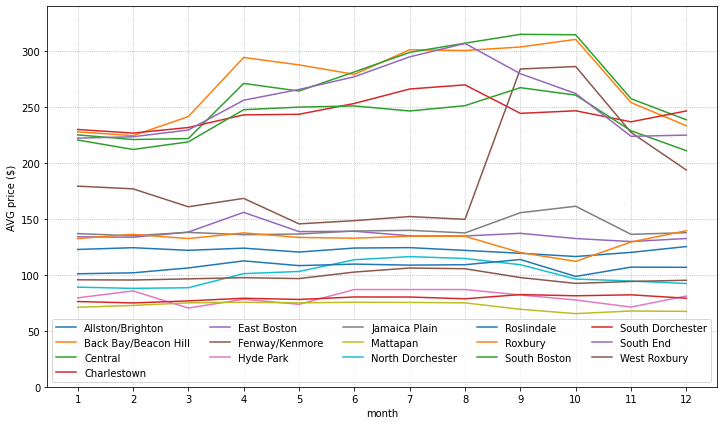

In [164]:
month_district_stat = (calendar_sample
                      .merge(listing[['id', 'district']], 
                             left_on='listing_id', right_on='id',
                            how='left')
                      .groupby(by=['district', 'month'])
                      .agg({'price': 'mean',
                            'available_lid': pd.Series.nunique})
                      .reset_index())

plt.figure(figsize=(12,7))
for d in month_district_stat['district'].unique():
    selection = month_district_stat[month_district_stat['district']==d]
    plt.plot(selection['month'], selection['price'], label=d)
plt.grid(linestyle=':')
plt.legend(ncol=5, loc='lower left')
plt.xticks(month_district_stat['month'].unique())
plt.ylim(0, 340)
plt.ylabel('AVG price ($)')
plt.xlabel('month')
plt.show()

In [33]:
# price at working vs weekends
availability_wd = pd.pivot_table(calendar_sample, 
                              index='listing_id', 
                              columns='weekend', 
                              values='price', 
                              aggfunc='mean').reset_index()
availability_wd = availability_wd.rename(columns={0: 'working',
                                                  1: 'weekend'})
availability_wd['delta'] = availability_wd['weekend'] - availability_wd['working']
availability_wd['delta_percent'] = availability_wd['delta']/availability_wd['weekend']*100
availability_wd[:2]

weekend,listing_id,working,weekend,delta,delta_percent
0,6695,197.23176,197.857143,0.625383,0.316078
1,6976,65.00000,65.000000,0.000000,0.000000


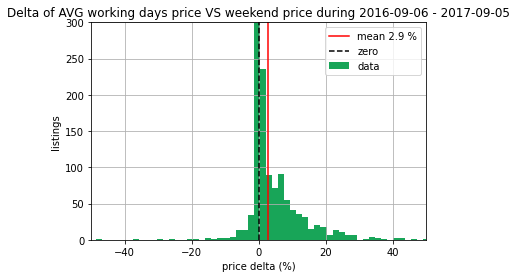

In [34]:
availability_wd['delta_percent'].hist(bins=200, color=colors[0], label='data')
plt.title('Delta of AVG working days price VS weekend price during 2016-09-06 - 2017-09-05')
plt.xlabel('price delta (%)')
plt.ylabel('listings')
plt.axvline(x=availability_wd['delta_percent'].mean(), color='red', 
            label=f'mean {round(availability_wd["delta_percent"].mean(), 1)} %')
plt.axvline(x=0, color='black', label='zero', linestyle='--')
plt.ylim(0,300)
plt.xlim(-50, 50)
plt.legend()
plt.show()

In [35]:
# pd.get_dummies(listing['amenities'].apply(pd.Series).stack()).sum(level=0)

#### reviews - comments on objects

In [61]:
reviews = pd.read_csv('Boston_Airbnb_data/reviews.csv')
reviews[:2]

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...


In [62]:
print('Date ranges in the reviews data: ', reviews['date'].min(), '-', reviews['date'].max())

Date ranges in the reviews data:  2009-03-21 - 2016-09-06


#### add sentiment scores

In [63]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dariasatco/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [64]:
def get_sentiment_score(text: str) -> float:
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

In [65]:
%%time
reviews['sentiment_score'] = reviews['comments'].fillna('').apply(lambda x: get_sentiment_score(x))

CPU times: user 5min 43s, sys: 965 ms, total: 5min 44s
Wall time: 5min 45s


In [69]:
sentiment_by_listing = reviews.groupby(by=['listing_id']).agg({'sentiment_score': 'mean'}).reset_index()

In [103]:
listing = listing.merge(sentiment_by_listing, left_on='id', right_on='listing_id', how='left')

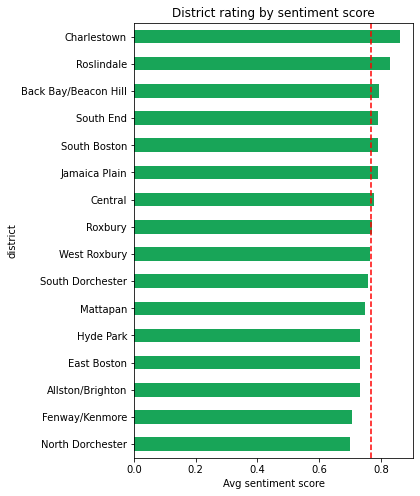

In [130]:
sentiment_by_district = listing.groupby(by='district').agg({'sentiment_score': 'mean'})

(sentiment_by_district
 .sort_values(by='sentiment_score')
 .plot(kind='barh', figsize=(5, 8), 
       legend=False, color=colors[0]))
plt.axvline(x=sentiment_by_district['sentiment_score'].mean(),
           color='red', linestyle='--')
plt.xlabel('Avg sentiment score')
plt.title('District rating by sentiment score')
plt.show()